# AMLB Visualizations
This notebook contains code to generate the training duration figure (Figure 8) from the paper "AMLB: an AutoML Benchmark" by Gijsbers et al. (2022). As input, it assumes "cleaned logs" which are available at `http://openml-test.win.tue.nl/amlb/*_cleaned.csv` and the `CleanResults` notebook shows how they are constructed from the raw results. 

In [1]:
import itertools
import math
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

In [2]:
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, add_rescale, is_old
from visualization import FRAMEWORK_TO_COLOR

In [3]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures"

for subfolder in ["CD", "duration", "inference", "performance"]:
    (FIGURE_DIRECTORY / subfolder).mkdir(parents=True, exist_ok=True)

In [4]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results = results[~results["framework"].isin(["NaiveAutoML", "TunedRandomForest"])]
results["framework"] = results["framework"].apply(get_print_friendly_name)

In [5]:
def add_horizontal_lines(ax, lines: tuple[tuple[float, str], ...]):
    """Draws horizontal lines specified by (y value, color)-pairs."""
    for y, color in lines:
        ax.axhline(y, color=color)

def box_plot(data, metric=None, ylog=False, title="", ylim=None, figsize=(16, 9), with_framework_names=True, add_counts=None, color_map=None):
    """Creates a boxplot with data["frameworks"] on the x-axis and data[`metric`] on the y-axis
    
    The figure's y-axis may be limited by `ylim` and the number of values outside this limit may be shown in the tick labels.
    """
    if add_counts and (add_counts != "outliers" and not isinstance(add_counts, dict)):
        raise ValueError("`add_counts` must be 'outliers' or a dictionary mapping each framework to a number.")
        
    color_map = color_map or FRAMEWORK_TO_COLOR
    color_map = {k: v for k, v in color_map.items() if k in data["framework"].unique()}
    
    metric = metric or data.metric.unique()[0]
    if metric.startswith("neg_"):
        pos_metric = metric[len("neg_"):]
        data[pos_metric], metric = -data[metric], pos_metric
        
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    seaborn.boxplot(
        data=data,
        x="framework",
        y=metric,
        order=color_map,
        hue="constraint" if data.constraint.nunique() > 1 else None,
        palette=color_map if data.constraint.nunique() == 1 else None,
        ax=ax,
        fliersize=1,
    )
    
    if ylog:
        ax.set_yscale("log")
        
    ax.set_ylabel(metric, size='xx-large')
    ax.set_xlabel("")
    ax.tick_params(axis='both', which = 'both', labelsize = 18)
    
    if title:
        ax.set_title(title, fontsize=18)
        
    # Dirty hack for displaying outliers, we overlap minor and major tick labels, where
    # minor labels are used to display the number of outliers, and major tick labels may
    # be used to display the framework names.
    constraint = data.constraint.unique()[0]
    smetric = data.metric.unique()[0]
    frameworks = color_map.keys()
    frameworks = [
        f"{fw if with_framework_names else ''}*" if is_old(fw, constraint, smetric) else fw 
        for fw in frameworks
    ]
    if add_counts:
        # There will be minor tick labels displayed for outliers,
        # to avoid rendering on top of each other, we offset the label location
        # with a dirty hack of using leading spaces :-) 
        frameworks = [f"   {fw}" for fw in frameworks]
    ax.tick_params(axis="x", which="major", rotation=-90)
    ax.set_xticks(*zip(*enumerate(frameworks)))
    
    if ylim:  
        ax.set_ylim(ylim)
        if add_counts != "outliers":
            print("Warning! Ylim is set but outliers are not reported.")
    
    counts = []
    if add_counts:
        if add_counts == "outliers":
            add_counts = {}
            for framework in color_map:
                framework_outliers = data[(data["framework"] == framework) & (data[metric] < ylim[0])]
                add_counts[framework] = f"{len(framework_outliers)}"

        # We need to offset the minor tick labels, otherwise they won't render.
        ax.set_xticks(
            ticks=[i-0.01 for i in range(len(color_map))],
            labels=[f"[{add_counts.get(f, 'x')}]" for f in color_map], 
            minor=True
        )
        
    return fig, ax

generating train-duration-1h8c_gp3.pdf
generating train-duration-4h8c_gp3.pdf


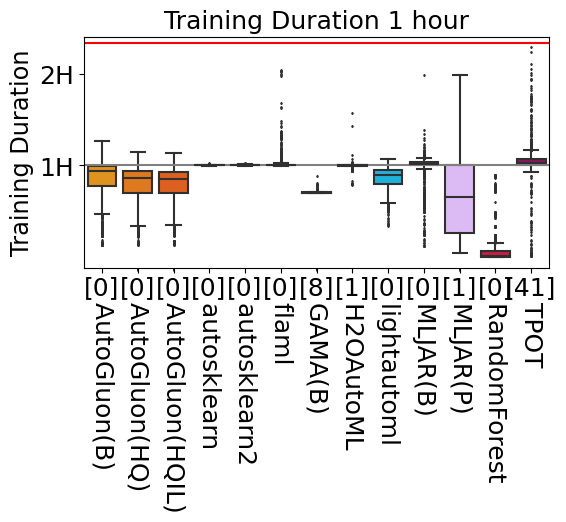

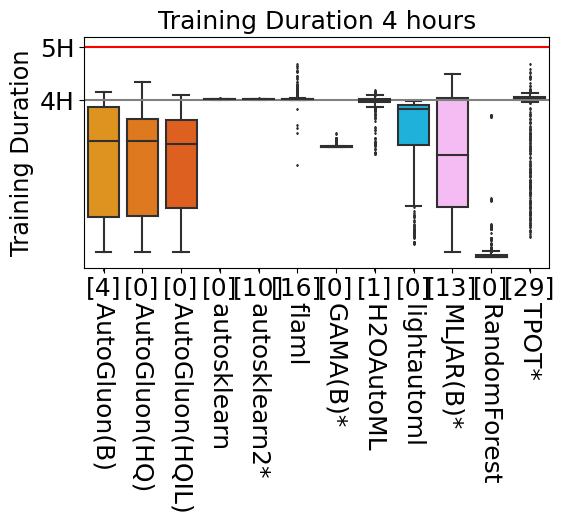

In [6]:
from matplotlib.backends.backend_pdf import PdfPages

for constraint in results.constraint.unique():
    time_budget = get_print_friendly_name(constraint)
    data = results[results["constraint"] == constraint]
    data = data[~data["framework"].isin(["constantpredictor"])]
    
    data["timeout"] = data["info"].apply(lambda msg: isinstance(msg, str) and "Interrupting thread MainThread" in msg)
    timeout_counts = dict(data[["framework", "timeout"]].groupby("framework").sum()["timeout"])
    filename = f"train-duration-{constraint}.pdf".replace(" ", "-")
    print("generating", filename)

    time_limit = 3600 if constraint == "1h8c_gp3" else 3600*4
    fig, ax = box_plot(
        data,
        metric="training_duration", 
        title=f"Training Duration {time_budget}", 
        #ylim=[-3 if metric != "auc" or constraint !="4h8c_gp3" else -7, 0],
        figsize=(6, 3),
        add_counts=timeout_counts,
        with_framework_names=True, # ttype == "regression",
    )
    add_horizontal_lines(ax, ((time_limit, "grey"), (time_limit+3600+1200, "red")))
    ax.set_ylabel("Training Duration")
    if constraint == "1h8c_gp3":
        ax.set_yticks([3600, 7200], ["1H", "2H"])
    if constraint == "4h8c_gp3":
        ax.set_yticks([3600*4, 3600*5+1200], ["4H", "5H"])


    with PdfPages(str(FIGURE_DIRECTORY / "duration" / filename)) as f:
        f.savefig(fig, bbox_inches="tight")

## From Disk Batch Inference Speed

generating inference-row-per-s-1h8c_gp3.pdf


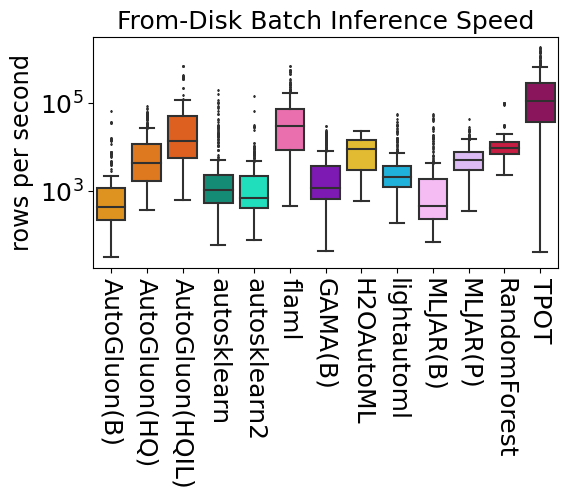

In [7]:
constraint = "1h8c_gp3"
time_budget = get_print_friendly_name(constraint)
data = results[results["constraint"] == constraint]
data = data[~data["framework"].isin(["constantpredictor"])]

data["timeout"] = data["info"].apply(lambda msg: isinstance(msg, str) and "Interrupting thread MainThread" in msg)
timeout_counts = dict(data[["framework", "timeout"]].groupby("framework").sum()["timeout"])
data["row/s"] = 10_000 / data["infer_batch_size_file_10000"]
filename = f"inference-row-per-s-{constraint}.pdf".replace(" ", "-")
print("generating", filename)

time_limit = 3600 if constraint == "1h8c_gp3" else 3600*4
fig, ax = box_plot(
    data,
    metric="row/s", 
    title=f"From-Disk Batch Inference Speed", 
    figsize=(6, 3),
    add_counts=False,#timeout_counts,
    with_framework_names=True, # ttype == "regression",
)
ax.set_ylabel("rows per second")
ax.set_yscale("log")

with PdfPages(str(FIGURE_DIRECTORY / "inference" / filename)) as f:
    f.savefig(fig, bbox_inches="tight")

## Inference Speed on Single-Row DataFrame

generating inference-row-per-s-dataframe-1h8c_gp3.pdf


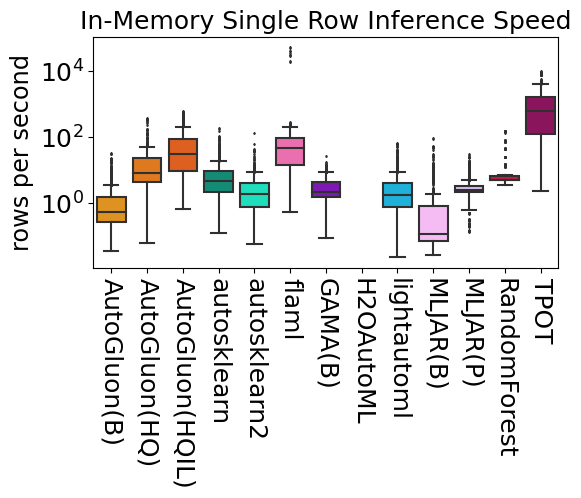

In [8]:
constraint = "1h8c_gp3"
time_budget = get_print_friendly_name(constraint)
data = results[results["constraint"] == constraint]
data = data[~data["framework"].isin(["constantpredictor"])]

data["timeout"] = data["info"].apply(lambda msg: isinstance(msg, str) and "Interrupting thread MainThread" in msg)
timeout_counts = dict(data[["framework", "timeout"]].groupby("framework").sum()["timeout"])
data["row/s"] = 1 / data["infer_batch_size_df_1"]
filename = f"inference-row-per-s-dataframe-{constraint}.pdf".replace(" ", "-")
print("generating", filename)

time_limit = 3600 if constraint == "1h8c_gp3" else 3600*4
fig, ax = box_plot(
    data,
    metric="row/s", 
    title=f"In-Memory Single Row Inference Speed", 
    figsize=(6, 3),
    add_counts=False,#timeout_counts,
    with_framework_names=True, # ttype == "regression",
)
ax.set_ylabel("rows per second")
ax.set_yscale("log")

with PdfPages(str(FIGURE_DIRECTORY / "inference" / filename)) as f:
    f.savefig(fig, bbox_inches="tight")

# Inference Time on Test Set
For completeness, this was used in the 2022 version of the paper.

generating inference-predict-duration-1h8c_gp3.pdf


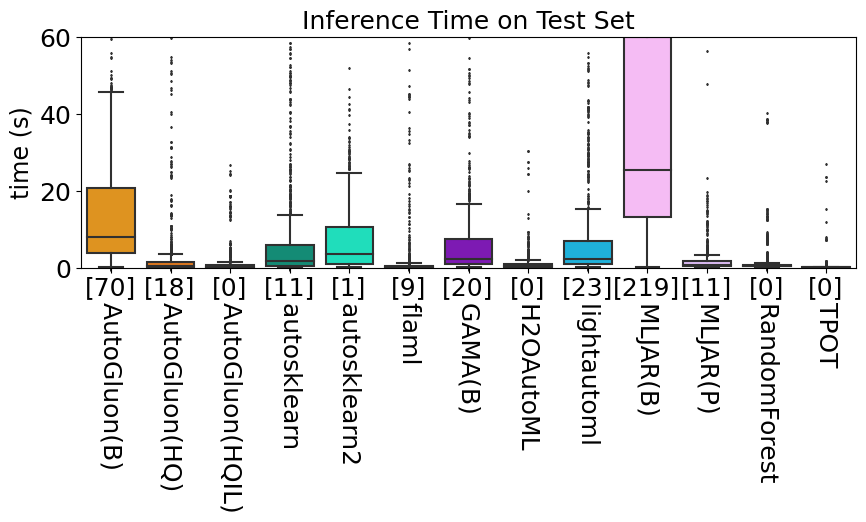

In [9]:
constraint = "1h8c_gp3"
time_budget = get_print_friendly_name(constraint)
data = results[results["constraint"] == constraint]
data = data[~data["framework"].isin(["constantpredictor"])]

data["timeout"] = data["predict_duration"].apply(lambda time: time > 60)
timeout_counts = dict(data[["framework", "timeout"]].groupby("framework").sum()["timeout"])

filename = f"inference-predict-duration-{constraint}.pdf".replace(" ", "-")
print("generating", filename)

time_limit = 3600 if constraint == "1h8c_gp3" else 3600*4
fig, ax = box_plot(
    data,
    metric="predict_duration", 
    title=f"Inference Time on Test Set", 
    figsize=(10, 3),
    add_counts=timeout_counts,
    with_framework_names=True, # ttype == "regression",
)
ax.set_ylabel("time (s)")
ax.set_ylim([0,60])

with PdfPages(str(FIGURE_DIRECTORY / "inference" / filename)) as f:
    f.savefig(fig, bbox_inches="tight")

## Normalized Test Set Inference Speed
For completeness. This was used in the 2022 version of the paper.

generating inference-normalized-predict-duration-1h8c_gp3.pdf


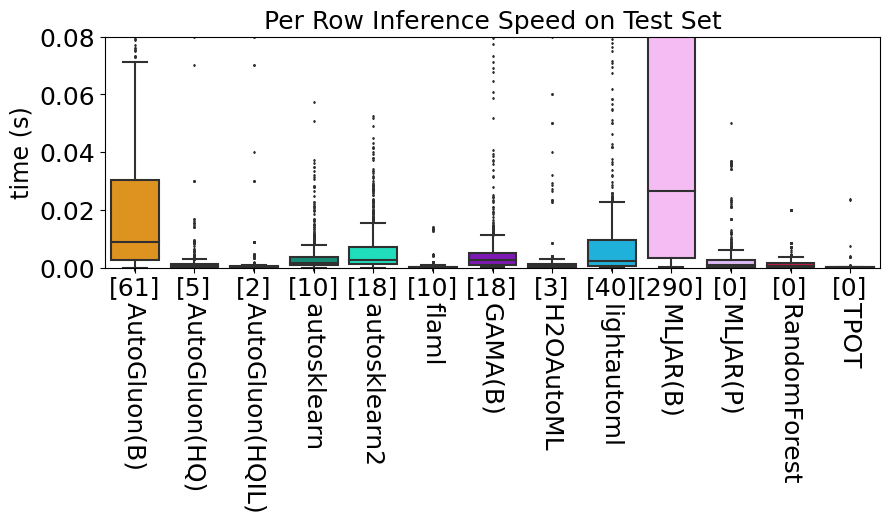

In [10]:
constraint = "1h8c_gp3"
time_budget = get_print_friendly_name(constraint)
data = results[results["constraint"] == constraint]
data = data[~data["framework"].isin(["constantpredictor"])]
metadata = pd.read_csv(DATA_DIRECTORY / "metadata.csv").set_index("name")
data = data.join(metadata["NumberOfInstances"], on="task")

data["s/row"] = data["predict_duration"] / (data["NumberOfInstances"]/10)

data["timeout"] = data["s/row"].apply(lambda time: time > 0.08)
timeout_counts = dict(data[["framework", "timeout"]].groupby("framework").sum()["timeout"])
filename = f"inference-normalized-predict-duration-{constraint}.pdf".replace(" ", "-")
print("generating", filename)

time_limit = 3600 if constraint == "1h8c_gp3" else 3600*4
fig, ax = box_plot(
    data,
    metric="s/row", 
    title=f"Per Row Inference Speed on Test Set", 
    figsize=(10, 3),
    add_counts=timeout_counts,
    with_framework_names=True, # ttype == "regression",
)
ax.set_ylabel("time (s)")
ax.set_ylim([0,0.08])

with PdfPages(str(FIGURE_DIRECTORY / "inference" / filename)) as f:
    f.savefig(fig, bbox_inches="tight")